# Data description & Problem statement: 
The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes. Please check the description at: https://archive.ics.uci.edu/ml/datasets/auto+mpg

* The data has 398 rows and 9 variables.
* This is a Regression problem. We predict the Auto MPG.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc.
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build an initial XGBoost model, and evaluate it via C-V approach
- Use grid-search along with C-V approach to find the best hyperparameters of XGBoost model: Find the best XGBoost model (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the best XGBoost model with optimized hyperparameters on Test Dataset, by calculating:
     - AUC score
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision
     
Finally, calculate the Feature Importance. 

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/mpg/mpg.csv')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null int64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null int64
name            398 non-null object
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [3]:
df['horsepower'] = df['horsepower'].apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)
df.drop(['name' ], axis=1, inplace=True)

In [4]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
for name in ['origin']:
    encode_text_dummy(df, name)
    
df.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin-1,origin-2,origin-3
0,18.0,8,307.0,130.0,3504,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,0,0


In [5]:
X=df.drop(['mpg'], axis=1)
y=np.log(df['mpg'])

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

# Re-scaling & Polynomial Interactions:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

scalor_X=MinMaxScaler().fit(pd.DataFrame(X_train))
X_train=scalor_X.transform(pd.DataFrame(X_train))
X_test=scalor_X.transform(pd.DataFrame(X_test))

scaler_y=MinMaxScaler().fit(pd.DataFrame(y_train))
y_train=scaler_y.transform(pd.DataFrame(y_train))
y_test=scaler_y.transform(pd.DataFrame(y_test))

In [6]:
# Building the Initial Model & Cross-Validation: 
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

model=XGBRegressor() 
kfold=KFold(n_splits=5, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold)

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.87773566 0.85444808 0.87122946 0.88404971 0.92225803] 

Accuracy: 0.88 (+/- 0.02)


In [30]:
# Grid-Search for the best model parameters: 
from sklearn.model_selection import GridSearchCV

param={'max_depth':[2, 4, 6], 'min_child_weight':[1, 2, 3], 'gamma': [ 0, 0.05, 0.1], 'subsample':[0.7, 1]}

kfold=KFold(n_splits=3, shuffle=True, random_state=42)
grid_search=GridSearchCV(XGBRegressor(), param, cv=kfold, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
14,0.041223,3.291267e-03,0.000997,3.371748e-07,0,6,2,0.7,"{'gamma': 0, 'max_depth': 6, 'min_child_weight...",0.867968,0.879424,0.895381,0.880924,0.011241,1,0.998051,0.998048,0.998057,0.998052,0.000004
7,0.043217,1.673515e-02,0.004988,4.952194e-03,0,4,1,1,"{'gamma': 0, 'max_depth': 4, 'min_child_weight...",0.860756,0.882366,0.898116,0.880413,0.015315,2,0.992368,0.992299,0.992502,0.992390,0.000084
16,0.034907,8.104673e-07,0.001329,4.705843e-04,0,6,3,0.7,"{'gamma': 0, 'max_depth': 6, 'min_child_weight...",0.869579,0.876125,0.891886,0.879197,0.009362,3,0.996221,0.996556,0.996605,0.996461,0.000171


In [31]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'gamma': 0, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.7}
Best validation accuracy:  0.88 (+/- 0.01)
Test score:  0.91


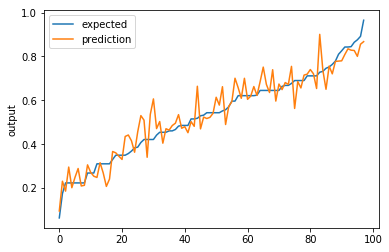

In [32]:
# Plot the Lift Chart:

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

pred=grid_search.predict(X_test)
chart_regression(pred.flatten(), np.array(y_test), sort=True)

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_inv=scaler_y.inverse_transform(pd.DataFrame(pred))
y_test_inv=scaler_y.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(np.e**y_test_inv, np.e**pred_inv))
print('Test rmse: ', rmse)

Test rmse:  2.3973966962847957


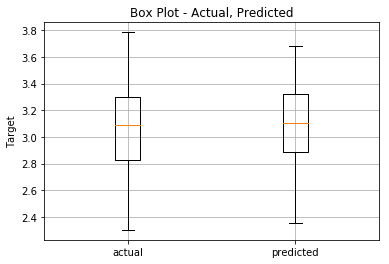

In [34]:
plt.boxplot([y_test_inv.ravel(), pred_inv.ravel()], labels=['actual','predicted'])
plt.title('Box Plot - Actual, Predicted')
plt.ylabel('Target')
plt.grid(True)

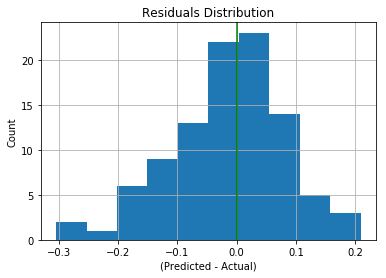

In [35]:
# Over prediction and Under Prediction needs to be balanced:
# Training Data Residuals
residuals = y_test_inv.ravel()-pred_inv.ravel()

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')
plt.show()

('weight', 0.2177264)
('horsepower', 0.19460501)
('model_year', 0.18111753)
('acceleration', 0.16570328)
('displacement', 0.14450867)
('cylinders', 0.055876687)
('origin-1', 0.019267824)
('origin-2', 0.015414258)
('origin-3', 0.0057803467)


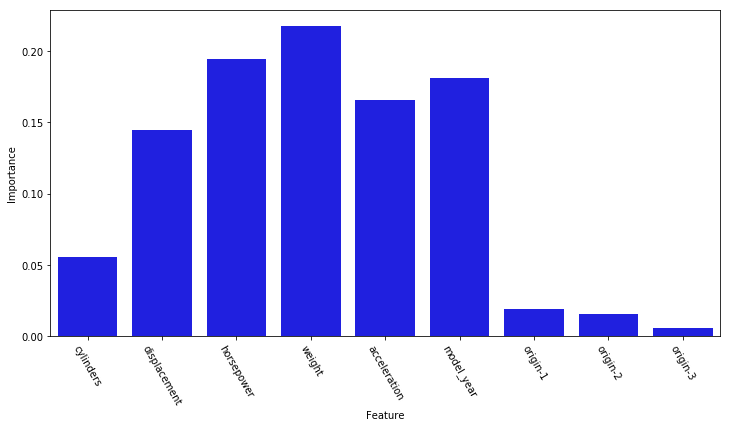

In [36]:
im=XGBRegressor().fit(X, y).feature_importances_

# Sort & Plot:
d=dict(zip(np.array(X.columns), im))
k=sorted(d,key=lambda i: d[i], reverse= True)
[print((i,d[i])) for i in k]

# Plot:
c1=pd.DataFrame(np.array(im),  columns=["Importance"])
c2=pd.DataFrame(np.array(X.columns),columns=["Feature"])

fig, ax = plt.subplots(figsize=(12,6)) 
sns.barplot(x="Feature", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)
plt.xticks(rotation=-60)
plt.show()